In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import random
import string
import torch
import wandb

import numpy as np
import pandas as pd

from Code import Dataloader
from Code import Dataset
from Code import ModelBertV1
from Code import Train

from sklearn.model_selection import train_test_split

In [29]:
import Code.ModelBertV1 as ModelLib

In [30]:

def load_model(path, map_location='cuda'):
    checkpoint = torch.load(path, map_location=map_location, weights_only=False)
    config = checkpoint.get('config', None)
    config['df_config']['address_limit'] = config['cnt_known_address']
    model = getattr(ModelBertV1, config['model'])(
                known_address_len=config['cnt_known_address'],
                **config['model_params']
            )

    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint.get('epoch', None)

    return model, config, epoch

In [31]:
model, config, epoch = load_model(model,
                                  '/home/motatasher/Documents/University/Diploma/' \
                                  'Diploma/models/model training on eth dataset v1, ' \
                                  'tensor predict_qjmctedofg/model_epoch_151.pt')

AttributeError: 'BertForTransactionRegressionV1' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [7]:
df_raw = getattr(Dataloader, config['dataset_fabric'])(**config['df_config'])
print(config['cnt_known_address'])
known_address = pd.concat([df_raw['to'], df_raw['from']])\
                    .value_counts()[:config['cnt_known_address']]\
                    .keys().sort_values()

dataset_params = {
    'known_address': list(known_address),
    'sample_len': config['sample_len']
}

train_data, val_data = train_test_split(df_raw, test_size=1/4, shuffle=False)
print(f"square std of all: {df_raw['value'].std() ** 2}\nTrain: {train_data['value'].std() ** 2}\nVal: {val_data['value'].std() ** 2}")

train_loader = torch.utils.data.DataLoader(
    Dataset.TransactionDataset(train_data, **dataset_params, apply_log=config['use_log']),
    batch_size=config['train_batch_size'],
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    Dataset.TransactionDataset(val_data, **dataset_params, apply_log=config['use_log']),
    batch_size=config['test_batch_size'],
    shuffle=False,
)


100
square std of all: 9339.15481948
Train: 7457.2568177150715
Val: 14984.751691976424


In [8]:
device = 'cuda:1'

In [9]:
model = model.to(device)

In [10]:
import itertools
from tqdm import tqdm

def get_ts(data):
    return (data.loc[:, 'timestamp'].values.astype('datetime64[ns]') -  np.datetime64('1970-01-01T00:00:00')) \
            / np.timedelta64(1, 'ns')

from torch.utils import data
from torch.utils.data import DataLoader
from tqdm import tqdm

class TimeEmbeddingRegressionDataset(data.Dataset):
    def __init__(self, df, model, sample_len, apply_log=False,
                 device='cuda', batch_size=128, cnt_batchs=8):
        self.model = model.eval().to(device)
        self.df = df.reset_index(drop=True)
        self.sample_len = sample_len
        self.apply_log = apply_log
        self.device = device
        self.batch_size = batch_size
        self.cnt_batchs = cnt_batchs

        self.samples = self.build_samples(df)
        self.embeddings, self.targets = self.compute_all_embeddings()

    def build_samples(self, df):
        return list(range(
            min(len(df), self.batch_size * self.sample_len * self.cnt_batchs) // self.sample_len * self.sample_len))

    def __len__(self):
        return len(self.samples)

    def compute_all_embeddings(self):
        all_embs, all_tgts = [], []
        loader = DataLoader(self.samples[::self.sample_len], batch_size=self.batch_size, shuffle=True)

        for batch_indices in tqdm(itertools.islice(loader, self.cnt_batchs), desc="Embedding calculation", total=
                                  min(self.cnt_batchs, len(loader))):
            batch = [self._prepare_sample(int(idx)) for idx in batch_indices]

            model_inputs = self._collate_inputs([b[0] for b in batch])
            targets = torch.stack([b[1] for b in batch]).to(self.device)

            with torch.no_grad():
                result = self.model(**model_inputs)['result']

            all_embs.append(result.cpu())
            all_tgts.append(targets.cpu())

        print(torch.cat(all_embs, 0).shape)
        return torch.cat(all_embs, 0).reshape(-1, all_embs[0].shape[-1]), torch.cat(all_tgts, 0).reshape(-1, 1)

    def _prepare_sample(self, idx):
        i = idx
        batch_df = self.df.iloc[i:i + self.sample_len]
        ts = get_ts(batch_df)
        time_features = Dataset.extract_time_features(ts)
        from_ind = batch_df['from'].values
        to_ind = batch_df['to'].values
        values = batch_df['value'].values

        volume_converter = lambda x: x
        if self.apply_log:
            volume_converter = lambda x: np.log(x)

        sample = {
            'numeric_features': torch.tensor(values, dtype=torch.float).T.unsqueeze(0).unsqueeze(-1),
            'from_address': torch.tensor(from_ind, dtype=torch.long).T.unsqueeze(0),
            'to_address': torch.tensor(to_ind, dtype=torch.long).T.unsqueeze(0),
            'time_features': torch.tensor(time_features, dtype=torch.float).T.unsqueeze(0),
            'value': torch.tensor(volume_converter(values)).unsqueeze(0).unsqueeze(-1)
        }

        msk_ind, change_ind, save_ind, model_input = Train.batch_to_model(
            sample,
            p_msk=0.0,
            p_change=0.0,
            p_save=1.0,
            device=self.device,
            change_strategy=Train.uniform_change_strategy
        )

        target = torch.tensor(ts, dtype=torch.float)
        return model_input, target

    def _collate_inputs(self, input_list):
        batched = {}
        for key in input_list[0].keys():
            batched[key] = torch.cat([torch.tensor(item[key]) for item in input_list], dim=0)
        return batched

    def __getitem__(self, idx):
        return self.embeddings[idx], self.targets[idx]


In [21]:
eazy_df = TimeEmbeddingRegressionDataset(df_raw, model, 100, apply_log=True, cnt_batchs=400)

Embedding calculation:   0%|          | 0/95 [00:00<?, ?it/s]/tmp/ipykernel_3079870/1555572793.py:72: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  'numeric_features': torch.tensor(values, dtype=torch.float).T.unsqueeze(0).unsqueeze(-1),
/tmp/ipykernel_3079870/1555572793.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batched[key] = torch.cat([torch.tensor(item[key]) for item in input_list], dim=0)
Embedding calculation: 100%|██████████| 95/95 [00:32<00:00,  2.95it/s]

torch.Size([12148, 100, 64])


In [89]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import datetime

class SimpleRegressor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        return self.net(x)

def train_time_regressor(model, train_dataloader, val_dataloader, num_epochs=100, lr=10, device='cuda', std=1, mean=0, normilize=True):
    std = float(std)
    mean = float(mean)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-8,
        threshold=1,
    )

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for emb_time, target in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} - Train"):
            if normilize:
                emb_time = emb_time / emb_time.norm(2, 1, keepdim=True)
            emb_time = emb_time.to(device)
            target = (target.to(device).unsqueeze(-1).float() - mean) / std

            pred = model(emb_time)
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for emb_time, target in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} - Val"):
                if normilize:
                    emb_time = emb_time / emb_time.norm(2, 1, keepdim=True)
                emb_time = emb_time.to(device)
                target = (target.to(device).unsqueeze(-1).float() - mean) / std

                pred = model(emb_time)
                loss = criterion(pred, target)
                total_val_loss += loss.item()

        avg_val_loss = (total_val_loss / len(val_dataloader)) ** 0.5 * std
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}")
        print(f"\nLr: {optimizer.param_groups[0]['lr']}")
        print(f"\nTrain Loss: {(total_train_loss / len(train_dataloader)) ** 0.5 * std:.4f}")
        print(f"\nVal Loss: {avg_val_loss:.4f}")
        print(f"\nTimedelta: {datetime.timedelta(seconds=avg_val_loss)}")


In [90]:
time_model = SimpleRegressor(32)

In [91]:
dataloader =  DataLoader(eazy_df, 2 ** 14, drop_last=True, num_workers=12, persistent_workers=True, pin_memory=True)

In [92]:
train_time_regressor(time_model, dataloader,
                     lr=1, device=device, std=eazy_df[:][1].std(), mean=eazy_df[:][1].mean())

/home/motatasher/miniconda3/envs/DiplomaIsupov/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1:   0%|          | 0/74 [00:00<?, ?it/s]

/home/motatasher/miniconda3/envs/DiplomaIsupov/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16384, 1, 1])) that is different to the input size (torch.Size([16384, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1: 100%|██████████| 74/74 [00:02<00:00, 28.92it/s]


Epoch 1
Lr: 1
Loss: 2271391.5484
timedelta 26 days, 6:56:31.548361


Epoch 2: 100%|██████████| 74/74 [00:01<00:00, 46.42it/s]


Epoch 2
Lr: 1
Loss: 263269.0129
timedelta 3 days, 1:07:49.012857


Epoch 3: 100%|██████████| 74/74 [00:01<00:00, 39.33it/s]


Epoch 3
Lr: 1
Loss: 263117.1862
timedelta 3 days, 1:05:17.186236


Epoch 4: 100%|██████████| 74/74 [00:01<00:00, 41.35it/s]


Epoch 4
Lr: 1
Loss: 263178.3276
timedelta 3 days, 1:06:18.327610


Epoch 5: 100%|██████████| 74/74 [00:02<00:00, 36.03it/s]


Epoch 5
Lr: 1
Loss: 263219.4992
timedelta 3 days, 1:06:59.499175


Epoch 6: 100%|██████████| 74/74 [00:01<00:00, 38.25it/s]


Epoch 6
Lr: 0.5
Loss: 263239.8841
timedelta 3 days, 1:07:19.884091


Epoch 7: 100%|██████████| 74/74 [00:01<00:00, 38.78it/s]


Epoch 7
Lr: 0.5
Loss: 263131.8098
timedelta 3 days, 1:05:31.809831


Epoch 8: 100%|██████████| 74/74 [00:02<00:00, 34.54it/s]


Epoch 8
Lr: 0.5
Loss: 263109.7832
timedelta 3 days, 1:05:09.783230


Epoch 9: 100%|██████████| 74/74 [00:02<00:00, 29.86it/s]


Epoch 9
Lr: 0.5
Loss: 263134.6167
timedelta 3 days, 1:05:34.616711


Epoch 10: 100%|██████████| 74/74 [00:02<00:00, 34.69it/s]


Epoch 10
Lr: 0.5
Loss: 263157.6705
timedelta 3 days, 1:05:57.670452


Epoch 11: 100%|██████████| 74/74 [00:02<00:00, 31.84it/s]


Epoch 11
Lr: 0.5
Loss: 263179.2268
timedelta 3 days, 1:06:19.226779


Epoch 12: 100%|██████████| 74/74 [00:01<00:00, 43.87it/s]


Epoch 12
Lr: 0.25
Loss: 263198.4099
timedelta 3 days, 1:06:38.409943


Epoch 13: 100%|██████████| 74/74 [00:01<00:00, 41.05it/s]


Epoch 13
Lr: 0.25
Loss: 263075.3073
timedelta 3 days, 1:04:35.307250


Epoch 14: 100%|██████████| 74/74 [00:02<00:00, 29.72it/s]


Epoch 14
Lr: 0.25
Loss: 263046.4684
timedelta 3 days, 1:04:06.468389


Epoch 15: 100%|██████████| 74/74 [00:01<00:00, 54.25it/s]


Epoch 15
Lr: 0.25
Loss: 263058.1362
timedelta 3 days, 1:04:18.136182


Epoch 16: 100%|██████████| 74/74 [00:01<00:00, 41.11it/s]


Epoch 16
Lr: 0.25
Loss: 263070.2000
timedelta 3 days, 1:04:30.199981


Epoch 17: 100%|██████████| 74/74 [00:02<00:00, 36.00it/s]


Epoch 17
Lr: 0.25
Loss: 263082.7562
timedelta 3 days, 1:04:42.756154


Epoch 18: 100%|██████████| 74/74 [00:01<00:00, 49.21it/s]


Epoch 18
Lr: 0.125
Loss: 263095.7871
timedelta 3 days, 1:04:55.787149


Epoch 19: 100%|██████████| 74/74 [00:01<00:00, 43.01it/s]


Epoch 19
Lr: 0.125
Loss: 263000.4123
timedelta 3 days, 1:03:20.412313


Epoch 20: 100%|██████████| 74/74 [00:01<00:00, 42.99it/s]


Epoch 20
Lr: 0.125
Loss: 262990.9677
timedelta 3 days, 1:03:10.967699


Epoch 21: 100%|██████████| 74/74 [00:01<00:00, 41.40it/s]


Epoch 21
Lr: 0.125
Loss: 262996.2312
timedelta 3 days, 1:03:16.231154


Epoch 22: 100%|██████████| 74/74 [00:02<00:00, 36.66it/s]


Epoch 22
Lr: 0.125
Loss: 263001.9413
timedelta 3 days, 1:03:21.941265


Epoch 23: 100%|██████████| 74/74 [00:01<00:00, 51.17it/s]


Epoch 23
Lr: 0.125
Loss: 263007.9464
timedelta 3 days, 1:03:27.946434


Epoch 24: 100%|██████████| 74/74 [00:01<00:00, 40.48it/s]


Epoch 24
Lr: 0.0625
Loss: 263014.2584
timedelta 3 days, 1:03:34.258408


Epoch 25: 100%|██████████| 74/74 [00:02<00:00, 33.50it/s]


Epoch 25
Lr: 0.0625
Loss: 262956.6192
timedelta 3 days, 1:02:36.619151


Epoch 26: 100%|██████████| 74/74 [00:01<00:00, 45.99it/s]


Epoch 26
Lr: 0.0625
Loss: 262955.5952
timedelta 3 days, 1:02:35.595187


Epoch 27: 100%|██████████| 74/74 [00:01<00:00, 43.63it/s]


Epoch 27
Lr: 0.0625
Loss: 262958.3900
timedelta 3 days, 1:02:38.389955


Epoch 28: 100%|██████████| 74/74 [00:02<00:00, 35.49it/s]


Epoch 28
Lr: 0.0625
Loss: 262961.2559
timedelta 3 days, 1:02:41.255932


Epoch 29: 100%|██████████| 74/74 [00:01<00:00, 53.17it/s]


Epoch 29
Lr: 0.0625
Loss: 262964.2503
timedelta 3 days, 1:02:44.250253


Epoch 30: 100%|██████████| 74/74 [00:01<00:00, 49.78it/s]


Epoch 30
Lr: 0.03125
Loss: 262967.3825
timedelta 3 days, 1:02:47.382454


Epoch 31: 100%|██████████| 74/74 [00:01<00:00, 37.07it/s]


Epoch 31
Lr: 0.03125
Loss: 262934.1504
timedelta 3 days, 1:02:14.150401


Epoch 32: 100%|██████████| 74/74 [00:01<00:00, 40.61it/s]


Epoch 32
Lr: 0.03125
Loss: 262934.6264
timedelta 3 days, 1:02:14.626431


Epoch 33: 100%|██████████| 74/74 [00:01<00:00, 42.94it/s]


Epoch 33
Lr: 0.03125
Loss: 262936.1029
timedelta 3 days, 1:02:16.102862


Epoch 34: 100%|██████████| 74/74 [00:02<00:00, 36.71it/s]


Epoch 34
Lr: 0.03125
Loss: 262937.6381
timedelta 3 days, 1:02:17.638125


Epoch 35: 100%|██████████| 74/74 [00:01<00:00, 39.61it/s]


Epoch 35
Lr: 0.03125
Loss: 262939.2327
timedelta 3 days, 1:02:19.232748


Epoch 36: 100%|██████████| 74/74 [00:02<00:00, 31.27it/s]


Epoch 36
Lr: 0.015625
Loss: 262940.9005
timedelta 3 days, 1:02:20.900515


Epoch 37: 100%|██████████| 74/74 [00:02<00:00, 34.93it/s]


Epoch 37
Lr: 0.015625
Loss: 262921.5808
timedelta 3 days, 1:02:01.580769


Epoch 38: 100%|██████████| 74/74 [00:01<00:00, 54.14it/s]


Epoch 38
Lr: 0.015625
Loss: 262922.0669
timedelta 3 days, 1:02:02.066895


Epoch 39: 100%|██████████| 74/74 [00:02<00:00, 35.01it/s]


Epoch 39
Lr: 0.015625
Loss: 262922.8620
timedelta 3 days, 1:02:02.861975


Epoch 40: 100%|██████████| 74/74 [00:01<00:00, 42.49it/s]


Epoch 40
Lr: 0.015625
Loss: 262923.7183
timedelta 3 days, 1:02:03.718336


Epoch 41: 100%|██████████| 74/74 [00:01<00:00, 39.39it/s]


Epoch 41
Lr: 0.015625
Loss: 262924.6121
timedelta 3 days, 1:02:04.612120


Epoch 42: 100%|██████████| 74/74 [00:02<00:00, 35.98it/s]


Epoch 42
Lr: 0.0078125
Loss: 262925.5385
timedelta 3 days, 1:02:05.538451


Epoch 43: 100%|██████████| 74/74 [00:01<00:00, 43.91it/s]


Epoch 43
Lr: 0.0078125
Loss: 262914.0817
timedelta 3 days, 1:01:54.081707


Epoch 44: 100%|██████████| 74/74 [00:01<00:00, 43.89it/s]


Epoch 44
Lr: 0.0078125
Loss: 262914.4344
timedelta 3 days, 1:01:54.434357


Epoch 45: 100%|██████████| 74/74 [00:01<00:00, 44.19it/s]


Epoch 45
Lr: 0.0078125
Loss: 262914.8820
timedelta 3 days, 1:01:54.882007


Epoch 46: 100%|██████████| 74/74 [00:02<00:00, 36.45it/s]


Epoch 46
Lr: 0.0078125
Loss: 262915.3722
timedelta 3 days, 1:01:55.372174


Epoch 47: 100%|██████████| 74/74 [00:02<00:00, 32.39it/s]


Epoch 47
Lr: 0.0078125
Loss: 262915.8823
timedelta 3 days, 1:01:55.882273


Epoch 48: 100%|██████████| 74/74 [00:01<00:00, 37.71it/s]


Epoch 48
Lr: 0.00390625
Loss: 262916.4165
timedelta 3 days, 1:01:56.416546


Epoch 49: 100%|██████████| 74/74 [00:01<00:00, 42.33it/s]


Epoch 49
Lr: 0.00390625
Loss: 262909.5152
timedelta 3 days, 1:01:49.515240


Epoch 50: 100%|██████████| 74/74 [00:01<00:00, 42.05it/s]


Epoch 50
Lr: 0.00390625
Loss: 262909.7500
timedelta 3 days, 1:01:49.749991


Epoch 51: 100%|██████████| 74/74 [00:01<00:00, 42.32it/s]


Epoch 51
Lr: 0.00390625
Loss: 262910.0136
timedelta 3 days, 1:01:50.013582


Epoch 52: 100%|██████████| 74/74 [00:01<00:00, 52.40it/s]


Epoch 52
Lr: 0.00390625
Loss: 262910.2968
timedelta 3 days, 1:01:50.296787


Epoch 53: 100%|██████████| 74/74 [00:01<00:00, 43.14it/s]


Epoch 53
Lr: 0.00390625
Loss: 262910.5923
timedelta 3 days, 1:01:50.592292


Epoch 54: 100%|██████████| 74/74 [00:01<00:00, 40.18it/s]


Epoch 54
Lr: 0.001953125
Loss: 262910.9007
timedelta 3 days, 1:01:50.900733


Epoch 55: 100%|██████████| 74/74 [00:01<00:00, 40.92it/s]


Epoch 55
Lr: 0.001953125
Loss: 262906.7120
timedelta 3 days, 1:01:46.712001


Epoch 56: 100%|██████████| 74/74 [00:02<00:00, 36.28it/s]


Epoch 56
Lr: 0.001953125
Loss: 262906.8620
timedelta 3 days, 1:01:46.862035


Epoch 57: 100%|██████████| 74/74 [00:01<00:00, 41.38it/s]


Epoch 57
Lr: 0.001953125
Loss: 262907.0183
timedelta 3 days, 1:01:47.018325


Epoch 58: 100%|██████████| 74/74 [00:01<00:00, 37.11it/s]


Epoch 58
Lr: 0.001953125
Loss: 262907.1816
timedelta 3 days, 1:01:47.181613


Epoch 59: 100%|██████████| 74/74 [00:01<00:00, 40.26it/s]


Epoch 59
Lr: 0.001953125
Loss: 262907.3547
timedelta 3 days, 1:01:47.354655


Epoch 60: 100%|██████████| 74/74 [00:01<00:00, 46.18it/s]


Epoch 60
Lr: 0.0009765625
Loss: 262907.5352
timedelta 3 days, 1:01:47.535226


Epoch 61: 100%|██████████| 74/74 [00:02<00:00, 36.09it/s]


Epoch 61
Lr: 0.0009765625
Loss: 262904.9845
timedelta 3 days, 1:01:44.984534


Epoch 62: 100%|██████████| 74/74 [00:02<00:00, 35.66it/s]


Epoch 62
Lr: 0.0009765625
Loss: 262905.0747
timedelta 3 days, 1:01:45.074661


Epoch 63: 100%|██████████| 74/74 [00:01<00:00, 47.56it/s]


Epoch 63
Lr: 0.0009765625
Loss: 262905.1685
timedelta 3 days, 1:01:45.168499


Epoch 64: 100%|██████████| 74/74 [00:01<00:00, 44.69it/s]


Epoch 64
Lr: 0.0009765625
Loss: 262905.2633
timedelta 3 days, 1:01:45.263291


Epoch 65: 100%|██████████| 74/74 [00:01<00:00, 43.58it/s]


Epoch 65
Lr: 0.0009765625
Loss: 262905.3617
timedelta 3 days, 1:01:45.361689


Epoch 66: 100%|██████████| 74/74 [00:01<00:00, 45.45it/s]


Epoch 66
Lr: 0.00048828125
Loss: 262905.4651
timedelta 3 days, 1:01:45.465070


Epoch 67: 100%|██████████| 74/74 [00:01<00:00, 44.94it/s]


Epoch 67
Lr: 0.00048828125
Loss: 262903.9180
timedelta 3 days, 1:01:43.917956


Epoch 68: 100%|██████████| 74/74 [00:02<00:00, 33.20it/s]


Epoch 68
Lr: 0.00048828125
Loss: 262903.9725
timedelta 3 days, 1:01:43.972456


Epoch 69: 100%|██████████| 74/74 [00:01<00:00, 41.60it/s]


Epoch 69
Lr: 0.00048828125
Loss: 262904.0249
timedelta 3 days, 1:01:44.024942


Epoch 70: 100%|██████████| 74/74 [00:01<00:00, 37.47it/s]


Epoch 70
Lr: 0.00048828125
Loss: 262904.0785
timedelta 3 days, 1:01:44.078489


Epoch 71: 100%|██████████| 74/74 [00:01<00:00, 43.35it/s]


Epoch 71
Lr: 0.00048828125
Loss: 262904.1342
timedelta 3 days, 1:01:44.134156


Epoch 72: 100%|██████████| 74/74 [00:02<00:00, 35.31it/s]


Epoch 72
Lr: 0.000244140625
Loss: 262904.1891
timedelta 3 days, 1:01:44.189081


Epoch 73: 100%|██████████| 74/74 [00:02<00:00, 32.01it/s]


Epoch 73
Lr: 0.000244140625
Loss: 262903.2637
timedelta 3 days, 1:01:43.263735


Epoch 74: 100%|██████████| 74/74 [00:01<00:00, 45.49it/s]


Epoch 74
Lr: 0.000244140625
Loss: 262903.2928
timedelta 3 days, 1:01:43.292788


Epoch 75: 100%|██████████| 74/74 [00:01<00:00, 41.21it/s]


Epoch 75
Lr: 0.000244140625
Loss: 262903.3212
timedelta 3 days, 1:01:43.321205


Epoch 76: 100%|██████████| 74/74 [00:01<00:00, 45.43it/s]


Epoch 76
Lr: 0.000244140625
Loss: 262903.3499
timedelta 3 days, 1:01:43.349940


Epoch 77: 100%|██████████| 74/74 [00:01<00:00, 43.29it/s]


Epoch 77
Lr: 0.000244140625
Loss: 262903.3799
timedelta 3 days, 1:01:43.379947


Epoch 78: 100%|██████████| 74/74 [00:01<00:00, 40.31it/s]


Epoch 78
Lr: 0.0001220703125
Loss: 262903.4084
timedelta 3 days, 1:01:43.408364


Epoch 79: 100%|██████████| 74/74 [00:01<00:00, 44.48it/s]


Epoch 79
Lr: 0.0001220703125
Loss: 262902.8621
timedelta 3 days, 1:01:42.862083


Epoch 80: 100%|██████████| 74/74 [00:01<00:00, 45.22it/s]


Epoch 80
Lr: 0.0001220703125
Loss: 262902.8764
timedelta 3 days, 1:01:42.876398


Epoch 81: 100%|██████████| 74/74 [00:01<00:00, 39.77it/s]


Epoch 81
Lr: 0.0001220703125
Loss: 262902.8884
timedelta 3 days, 1:01:42.888379


Epoch 82:  65%|██████▍   | 48/74 [00:01<00:00, 44.94it/s]


KeyboardInterrupt: 

In [62]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

def plot_time_predictions(model, dataloader, device='cuda', mean=0.0, std=1.0):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for emb_time, target in tqdm(dataloader, desc="Predicting"):
            emb_time = emb_time / emb_time.norm(2, 1, keepdim=True)
            emb_time = emb_time.to(device)
            target = target.unsqueeze(-1).float().to(device)

            preds = model(emb_time)
            preds_real = preds * std + mean
            targets_real = target

            all_preds.append(preds_real.cpu())
            all_targets.append(targets_real.cpu())

    preds_tensor = torch.cat(all_preds).squeeze().numpy()
    targets_tensor = torch.cat(all_targets).squeeze().numpy()

    # Перевод в datetime (unix time → datetime)
    # preds_datetime = [datetime.fromtimestamp(ts) for ts in preds_tensor]
    # targets_datetime = [datetime.fromtimestamp(ts) for ts in targets_tensor]

    return preds_tensor, targets_tensor

    

In [99]:
# dataloader_final =  DataLoader(eazy_df, 2 ** 14, drop_last=True, num_workers=12, shuffle=False)
data_mean, data_std = eazy_df[:][1].mean().numpy().item(), eazy_df[:][1].std().numpy().item()

preds_tensor, targets_tensor = plot_time_predictions(time_model, dataloader, device, data_mean, data_std)

Predicting:   0%|          | 0/74 [00:00<?, ?it/s]

Predicting: 100%|██████████| 74/74 [00:01<00:00, 41.05it/s]


In [106]:
time_model(eazy_df[:][0].to(device))

tensor([[0.0013],
        [0.0013],
        [0.0013],
        ...,
        [0.0013],
        [0.0013],
        [0.0013]], device='cuda:1', grad_fn=<AddmmBackward0>)

In [109]:
preds_datetime = [datetime.datetime.fromtimestamp(float(ts)) for ts in preds_tensor]
targets_datetime = [datetime.datetime.fromtimestamp(float(ts)) for ts in targets_tensor]

/tmp/ipykernel_3079870/1478482353.py:13: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min(preds_datetime), max(preds_datetime))
/tmp/ipykernel_3079870/1478482353.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


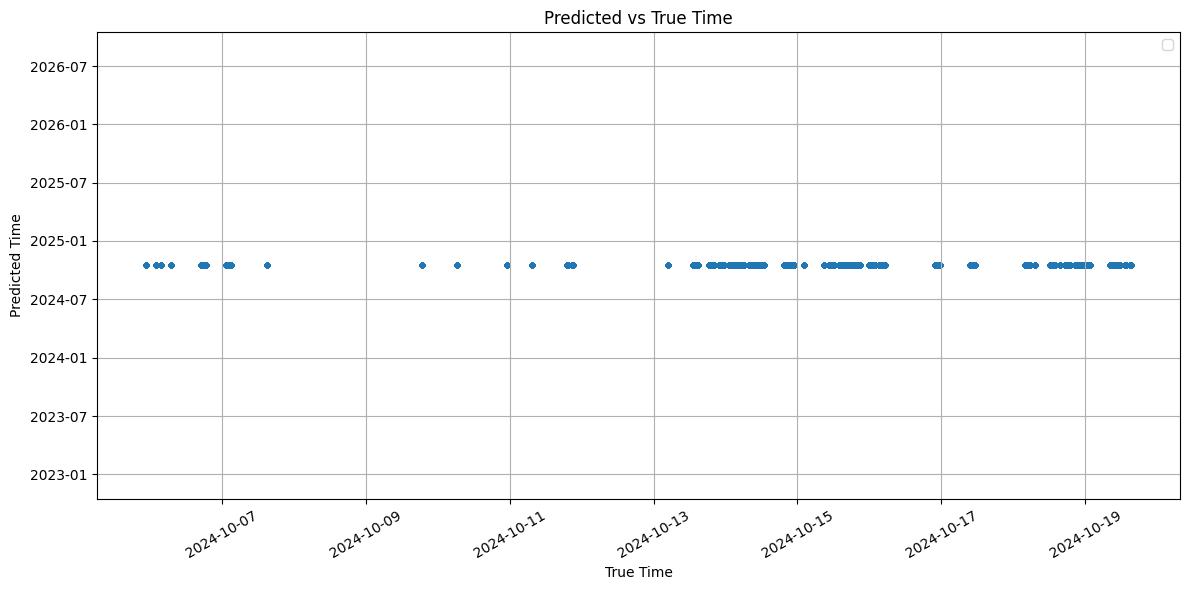

In [110]:
# Построение
plt.figure(figsize=(12, 6))
plt.scatter(targets_datetime, preds_datetime, alpha=0.3, s=8)
# plt.plot(
#     [min(targets_datetime), max(targets_datetime)],
#     [min(targets_datetime), max(targets_datetime)],
#     color='red', linestyle='--', label='y = x (ideal)'
# )
plt.xlabel("True Time")
plt.ylabel("Predicted Time")
plt.title("Predicted vs True Time")

plt.ylim(min(preds_datetime), max(preds_datetime))
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [270]:


# plot_predictions(time_model, DataLoader(eazy_df, 2 ** 14, drop_last=True, num_workers=12), device, coef=eazy_df[:][1].std())

In [78]:
torch.norm(eazy_df[0][0], dim=0).shape

torch.Size([64])

In [126]:
# (eazy_df[0][0] ** 2).sum(0) ** 0.5

In [125]:
#  torch.norm(eazy_df[0][0], 2, 0)

In [124]:
# (eazy_df[0][0] / torch.norm(eazy_df[0][0], 2, 0)).diff(1).norm(2, 0)

In [244]:
# train_time_regressor(SimpleRegressor(32), eazy_df, device=device)

Epoch 1:   0%|          | 0/1214800 [00:00<?, ?it/s]/home/motatasher/miniconda3/envs/DiplomaIsupov/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1:   0%|          | 1643/1214800 [00:03<41:00, 493.13it/s] 


KeyboardInterrupt: 

In [79]:
for a, b in eazy_df:
    print(b.shape)

torch.Size([100])


ValueError: could not determine the shape of object type 'Series'